In [14]:
%%capture
!pip install mediapy

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm
import imageio
import os
import mediapy
from scipy.special import softmax
%matplotlib inline

import torch._dynamo as dynamo
dynamo.config.suppress_errors = False

In [16]:
def get_mnist(train_transform=None,
              test_transform=None,
              batch_size=512,
              num_workers=2,
              pin_memory=True
              ):
  """
  Prepare train and test dataloaders

  Arguments:
    train_transform: Transforms to apply to the train data (default None)
    test_transform: Transforms to apply to the test data (default None)
    batch_size: Batch size for train and test dataloaders (default 64)
    num_workers: Number of separate subprocesses which load batches in parallel (default -1)
    pin_memory: If True, will copy tensors into pinned (page-locked), enabling faster transfer of batches to GPU(s); set to False if not using GPU (Default True)

  Returns:
    trainloader: A torch.utils.data.DataLoader object which yields train data in batches
    testloader: A torch.utils.data.DataLoader object which yields test data in batches
  """
  if train_transform is None:
    train_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

  if test_transform is None:
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

  train_data = datasets.MNIST(
      root='./data',
      train=True,
      download=True,
      transform=train_transform
  )
  test_data = datasets.MNIST(
      root='./data',
      train=True,
      download=True,
      transform=test_transform
  )

  if not torch.cuda.is_available():
      pin_memory = False
      
  trainloader = torch.utils.data.DataLoader(
      dataset=train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=pin_memory
  )
  testloader = torch.utils.data.DataLoader(
      dataset=test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=pin_memory
  )

  return trainloader, testloader

In [17]:
trainloader, testloader = get_mnist()

In [18]:
# for image_batch, label_batch in trainloader:
#   print(image_batch.shape)
#   print(label_batch.shape)
#   break

torch.Size([512, 1, 28, 28])
torch.Size([512])


In [19]:
class NeuronLevelModels(nn.Module):
  """
  Neuron Level Models which transform the pre-activation history, which contains
  pre-activations spanning the maximum number of internal ticks during training,
  into post-activation.
  """
  def __init__(self,
               d_model,
               d_out,
               history_length
               ):
    """
    Arguments:
      d_model: Dimension of pre-activations
      d_out: Dimension of post-activation
      history_length: Maximum number of internal ticks during training
    """
    super().__init__()
    self.w1 = nn.Parameter(
        torch.empty((history_length, d_out, d_model)).uniform_(
            -1 / math.sqrt(history_length + d_out),
             1 / math.sqrt(history_length + d_out)
        ),
        requires_grad=True
    )
    self.b1 = nn.Parameter(
        torch.zeros((1, d_out, d_model)),
        requires_grad=True
    )
    self.w2 = nn.Parameter(
        torch.empty((d_out, d_model)).uniform_(
            -1 / math.sqrt(d_out + d_model),
             1 / math.sqrt(d_out + d_model)
        ),
        requires_grad=True
    )
    self.b2 = nn.Parameter(
        torch.zeros((1, d_out)),
        requires_grad=True
    )

  def forward(self, x):
    """
    Forward pass of NeuronLevelModels layer, each neuron has its own MLP

    Arguments: 
        x: Input tensor representating pre-activations history.
    Returns:
        out: Output tensor representing post-activation at current internal tick.
    """
    out = torch.einsum('bdm,mhd->bhd', x, self.w1) + self.b1
    out = torch.einsum('bhd,hd->bh', out, self.w2) + self.b2

    return out

In [20]:
# logits = torch.randn(32, 8, 10)
# print(f'logits.shape = {logits.shape}')

# preds = F.softmax(logits, -1)
# log_preds = torch.log_softmax(logits, -1)
# entropy = -torch.sum(preds * log_preds, dim=-1)
# num_classes = preds.shape[-1]
# max_entropy = torch.log(torch.tensor(num_classes, dtype=torch.float32))
# ne = entropy / max_entropy
# ne.flatten(1).mean(-1).shape

logits.shape = torch.Size([32, 8, 10])


torch.Size([32])

In [21]:
# logits = torch.randn(8, 10)
# print(f'logits.shape = {logits.shape}')

# preds = F.softmax(logits, -1)
# log_preds = torch.log_softmax(logits, -1)
# entropy = -torch.sum(preds * log_preds, dim=-1)
# num_classes = preds.shape[-1]
# max_entropy = torch.log(torch.tensor(num_classes, dtype=torch.float32))
# ne = entropy / max_entropy
# ne.shape

In [22]:
class Identity(nn.Module):
  """Identity layer, outputs the same tensor as the output."""
  def __init__():
    super().__init__()

  def forward(self, x):
    return x

def compute_normalized_entropy(logits, reduction='mean'):
  """
  Computes normalized entropy, which is a measure of randomness, bounded in the range [0, 1].
  Greater normalized entropy implies greater randomness and lesser uncertainty.

  The normalized entropy is defined as:

        H_norm(p) = - (1 / log(k)) * Σ_i p_i * log(p_i)

    where:
        - p = (p_1, ..., p_k) is a probability distribution,
        - k is the number of classes,
        - H_norm(p) ∈ [0, 1].

    Interpretation:
        - H_norm(p) = 0 when the distribution is fully certain 
          (one class has probability 1, others 0).
        - H_norm(p) = 1 when the distribution is maximally uncertain 
          (all classes equally likely).

  Arguments:
      logits: Values representing preference for classes for each data point, can be converted into a probability (Boltzmann) distribution.

  Returns:
      normalized_entropy: Scalar representing normalized entropy.
  """
  preds = F.softmax(logits, dim=-1)
  log_preds = torch.log_softmax(logits, dim=-1)
  entropy = -torch.sum(preds * log_preds, dim=-1)
  num_classes = preds.shape[-1]
  max_entropy = torch.log(torch.tensor(num_classes, dtype=torch.float32))
  normalized_entropy = entropy / max_entropy
  if len(logits.shape) > 2 and reduction == 'mean':
    normalized_entropy = normalized_entropy.flatten(1).mean(-1)
  return normalized_entropy


class ContinuousThoughtMachine(nn.Module):
  """
  Class for transformations of input data throught the architecture of a Continuous Thought Machine.

  Arguments:
      d_input: Dimension of pre-activation vector for a single internal tick, and that of the attention output vector concatenated to the pre-activation vector.
      d_model: Number of neuron-level models in the architecture.
      dropout: A scalar value representing the magnitude of dropout to be applied at any point in the architecture. 
      history_length: Maximum number of internal ticks during training for which a pre-activation history is maintained.
      num_heads: Number of heads for the attention layer.
      out_dims: Dimension of the output vector for each data point at each internal tick; equal to the number of classes we are dealing with
      n_synch_action: Number of neurons to be used for synchronisation matrix, which is in turn going to be used for creating the attention output to be concatenated to pre-activation tensor.
      n_synch_out: Number of neurons to be used for synchronosation matrix, which in turn be transformed into output logits.
      synapse: nn.Sequential object representing the synapse layer (default None).
      backbone: nn.Sequential object representing the backbone which transforms input images to input features (default None).
  """
  def __init__(self,
               d_input,
               d_model,
               dropout,
               history_length,
               num_heads,
               out_dims,
               n_synch_action,
               n_synch_out,
               synapse=None,
               backbone=None
               ):
    super().__init__()
    self.d_input = d_input
    self.d_model = d_model
    self.dropout = dropout
    self.history_length = history_length
    self.num_heads = num_heads
    self.out_dims = out_dims
    self.n_synch_action = n_synch_action
    self.n_synch_out = n_synch_out
    if synapse is not None:
      self.synapse = synapse
    else:
      self.synapse = nn.Sequential(
        nn.Dropout(self.dropout),
        nn.LazyLinear(self.d_model * 2),
        nn.GLU(),
        nn.LayerNorm(self.d_model)
      )
    # self.post_activation has been initialized as start_activated_state in the official code repo
    self.post_activation = nn.Parameter(
        torch.zeros((self.d_model)).uniform_(
            -1 / math.sqrt(self.d_model),
             1 / math.sqrt(self.d_model)
        ),
        requires_grad=True
    )
    self.pre_activations_history = nn.Parameter(
        torch.empty((self.d_model, self.history_length)).uniform_(
            -1 / math.sqrt(self.d_model + self.history_length),
             1 / math.sqrt(self.d_model + self.history_length)
        ),
        requires_grad=True
    )
    self.attention = nn.MultiheadAttention(
        self.d_input,
        self.num_heads,
        self.dropout,
        batch_first=True
    )
    self.kv_projector = nn.Sequential(
        nn.LazyLinear(self.d_input),
        nn.LayerNorm(self.d_input)
    )
    self.q_projector = nn.Sequential(
        nn.LazyLinear(self.d_input),
        nn.LayerNorm(self.d_input)
    )
    self.output_projector = nn.LazyLinear(self.out_dims)
    self.nlms = NeuronLevelModels(
        d_model=self.d_model,
        d_out=self.d_model,
        history_length=self.history_length
    )
    if backbone is None:
        self.backbone = nn.Sequential(
            nn.LazyConv2d(
                d_input,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.LazyConv2d(
                d_input,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    else:
        self.backbone = backbone

    # Dimensions of the representations for synchronisation. For n_synch neurons, the pairwise-product would 
    # be a symmetric matrix, so we need only (n_synch * (n_sync + 1)) // 2 (including the diagonal elements) dimensions
    self.synch_representation_size_action = (self.n_synch_action * (self.n_synch_action + 1)) // 2
    self.synch_representation_size_out = (self.n_synch_out * (self.n_synch_out + 1)) // 2

    self.set_synchronisation_parameters('out')
    self.set_synchronisation_parameters('action')

  def set_synchronisation_parameters(self, synch_type):
    """
    Intializes the learning decay parameters, which give more weight to activations from recent ticks.

    Argument:
        synch_type: String value, either 'action' or 'out', representating whether the synchronisation is for 
                    generating a tensor to be concatenated to pre-activation tensor ('action') or for generating
                    a tensor to be transformed to output logits ('out').
    """
    synch_representation_size = self.synch_representation_size_action if synch_type == 'action' else self.synch_representation_size_out
    self.register_parameter(
        f'decay_params_{synch_type}',
        nn.Parameter(
            torch.zeros(synch_representation_size),
            requires_grad=True
        )
    )

  def compute_synchronisation(self, post_activation, decay_alpha, decay_beta, r, synch_type):
    """
    Computes synchonisation amongst chosen neurons.

    This method doesn't use the entire synchronisation matrix computed from the post-activation history, nor does it use a sampling of
    the neuron-interactions in the synchronisation matrix. It only relies on the post-activation tensor at the current internal tick. 
    The choice of this implementation, to lower computational requirements, is also the basis of the decision to not maintain a post-activation 
    history.

    This works fine for image classification on the MNIST dataset. For more complex problems, it would be worth trying the idea of using the entire (or at least a sample) 
    of the neuron-intearctions encoded in the synchronisation matrix. This implementation, using a recursive formulation, has been proposed in section K at the end of the paper. 
    
    Arguments:
        post_activation: Post-activation tensor at current internal tick
        decay_alpha: The numerator of the formula for recursive computation of synchronisation matrix.
        decay_beta: The denominator of the formula for recursive computation of synchronisation matrix.
        r: Learnable parameter deciding the rate of decay of post-activations from past internal ticks.
        synch_type: String value representing whether the synchronisation is to be used for computation of pre-activation or for logits.
    """
    if synch_type == 'action':
      n_synch = self.n_synch_action
      selected_left = selected_right = post_activation[:, -n_synch:]
    elif synch_type == 'out':
      n_synch = self.n_synch_out
      selected_left = selected_right = post_activation[:, :n_synch]

    outer = selected_left.unsqueeze(dim=2) * selected_right.unsqueeze(dim=1)
    i, j = torch.triu_indices(n_synch, n_synch)
    pairwise_product = outer[:, i, j]

    if decay_alpha is None or decay_beta is None:
      decay_alpha = pairwise_product
      decay_beta = torch.ones_like(pairwise_product)
    else:
      decay_alpha = r * decay_alpha + pairwise_product
      decay_beta = r * decay_beta + 1

    synchronisatioon = decay_alpha / torch.sqrt(decay_beta)
    return synchronisatioon, decay_alpha, decay_beta

  def compute_features(self, x):
    """
    Computes features to be fed to the CTM.

    Argument:
        x: Input tensor representing images batch(es).
    Returns:
        kv: Output tensor representing the keys and values to be used during attention computation.
    """
    input_features = self.backbone(x).flatten(2).transpose(1, 2)
    kv = self.kv_projector(input_features)

    return kv

  def compute_certainty(self, current_prediction):
    """
    Computes the certainty (and uncertainty) in the prediction produced at current internal tick.

    Arguments:
        current_prediction: Prediction, in terms of logits, at the current time step.
    Returns:
        current_certainty: Output tensor with certainty and uncertainty values.
    """
    ne = compute_normalized_entropy(current_prediction)
    current_certainty = torch.stack((ne, 1 - ne), -1)

    return current_certainty

  def forward(self, x, track=False):
    """
    Forward pass of ContinuousThoughtMachineLayer.

    Arguments:
        x: Input tensor representing batch(es) of images
        track: Whether to track pre-activations, post-activations, action synchronisation, 
               output synchronisation, and attention, for the purpose of visualization (default False).
    Returns:
        predictions: Predictions over the span of internal ticks, in terms of logits.
        certainties: Certainties (and uncertainties) for predictions over internal ticks.
        synch_out: Output synchronisation.
    """
    B = x.size(0)
    device = x.device

    if track:
      pre_activations_tracking = []
      post_activations_tracking = []
      synch_out_tracking = []
      synch_action_tracking = []
      attention_tracking = []

    kv = self.compute_features(x)

    pre_activations_history = self.pre_activations_history.unsqueeze(dim=0).expand(B, -1, -1)
    post_activation = self.post_activation.unsqueeze(dim=0).expand(B, -1)

    predictions = torch.empty(B, self.out_dims, self.history_length, device=device, dtype=x.dtype)
    certainties = torch.empty(B, 2, self.history_length, device=device, dtype=x.dtype)

    decay_alpha_action, decay_beta_action = None, None
    r_action = torch.exp(-self.decay_params_action).unsqueeze(0).repeat(B, 1)
    r_out = torch.exp(-self.decay_params_out).unsqueeze(0).repeat(B, 1)
    _, decay_alpha_out, decay_beta_out = self.compute_synchronisation(post_activation, None, None, r_out, synch_type='out')

    for tick_idx in range(self.history_length):
      synchronisation_action, decay_alpha_action, decay_beta_action = self.compute_synchronisation(
          post_activation,
          decay_alpha_action,
          decay_beta_action,
          r_action,
          synch_type='action'
      )

      q = self.q_projector(synchronisation_action).unsqueeze(dim=1)
      attn_out, attn_weights = self.attention(q, kv, kv, average_attn_weights=False, need_weights=True)
      attn_out = attn_out.squeeze(dim=1)
      pre_synapse_input = torch.concat([attn_out, post_activation], dim=-1)
      pre_activation = self.synapse(pre_synapse_input)

      pre_activations_history = torch.concat([pre_activations_history[:, :, :-1], pre_activation.unsqueeze(dim=-1)], dim=-1)
      post_activation = self.nlms(pre_activations_history)

      synchronisation_out, decay_alpha_out, decay_beta_out = self.compute_synchronisation(
          post_activation,
          decay_alpha_out,
          decay_beta_out,
          r_out,
          synch_type='out'
      )

      current_prediction = self.output_projector(synchronisation_out)
      current_certainty = self.compute_certainty(current_prediction)

      predictions[..., tick_idx] = current_prediction
      certainties[..., tick_idx] = current_certainty

      if track:
        pre_activations_tracking.append(pre_activations_history[:, :, -1].detach().cpu().numpy())
        post_activations_tracking.append(post_activation.detach().cpu().numpy())
        attention_tracking.append(attn_weights.detach().cpu().numpy())
        synch_out_tracking.append(synchronisation_out.detach().cpu().numpy())
        synch_action_tracking.append(synchronisation_action.detach().cpu().numpy())

    if track:
      return predictions, certainties, (np.array(synch_out_tracking), np.array(synch_action_tracking)), np.array(pre_activations_tracking), np.array(post_activations_tracking), np.array(attention_tracking)
    return predictions, certainties, synchronisation_out

In [23]:
def get_loss(predictions, certainties, targets, use_most_certain=True):
  """
  Given predictions and uncertainties over internal ticks, 
  computes the mean of the losses at the tick indices with 
  lowest loss and highest certainty. 

  If use_most_certain set to False, then the loss at the last tick index instead of the loss at the most certain tick index.

  Arguments:
      predictions: Predictions made over all the internal ticks.
      certainties: Certainties of the predictions made over all the internal ticks.
      targets: Ground truth values.
      use_most_certain: Whether to use the most certain tick index or, the last tick index (default True).
  Returns:
      loss: Computed mean loss value
      loss_index_2: Index of the 'certainty' loss, an indicator of whether the use_most_certain was True or False
  """
  losses = nn.CrossEntropyLoss(reduction='none')(
      predictions,
      torch.repeat_interleave(
          targets.unsqueeze(-1),
          predictions.size(-1),
          -1
      )
  )

  loss_index_1 = losses.argmin(dim=1)
  loss_index_2 = certainties[:, 1].argmax(-1)
  if not use_most_certain:
    loss_index_2[:] = -1

  batch_indexer = torch.arange(predictions.size(0), device=predictions.device)
  loss_minimum_ce = losses[batch_indexer, loss_index_1].mean()
  loss_selected = losses[batch_indexer, loss_index_2].mean()

  loss = (loss_minimum_ce + loss_selected) / 2
  return loss, loss_index_2

def calculate_accuracy(predictions, targets, where_most_certain):
  """
  Computes accuracy using predictions at the most certain internal tick, and the ground truth values.

  Arguments:
      predictions: History of predictions made by the CTM over internal ticks
      targets: Ground truth values
      where_most_certain: Tick indices corresponding to losses with most certain predictions
  Returns:
      accuracy: Scalar value representing computed accuracy
      
  """
  B = predictions.size(0)
  device = predictions.device

  predictions_at_most_certain_internal_tick = predictions.argmax(1)[torch.arange(B, device=device), where_most_certain].detach().cpu().numpy()
  accuracy = (targets.detach().cpu().numpy() == predictions_at_most_certain_internal_tick).mean()

  return accuracy

def update_training_curve_plot(fig, 
                               ax1, 
                               ax2, 
                               train_losses, 
                               test_losses, 
                               train_accuracies, 
                               test_accuracies, 
                               steps
                              ):
    """
    Plots training and testing curves (in terms of losses and accuracies), which are updated after every iteration

    Arguments:
        fig: The figure object containing the subplots
        ax1: The axis object used to plot losses
        ax2: The axis object used to plot accuracies
        train_losses: List of training losses recorded over iterations
        test_losses: List of test losses recorded at specific iterations
        train_accuracies: List of train accuracies recorded over iterations
        test_accuracies: List of test accuracies recorded at specific iterations
        steps: List of iterations at which test metrics were recorded
        
    """
    clear_output(wait=True)

    # Plot loss
    ax1.clear()
    ax1.plot(range(len(train_losses)), train_losses, 'b-', alpha=0.7, label=f'Train Loss: {train_losses[-1]:.3f}')
    ax1.plot(steps, test_losses, 'r-', marker='o', label=f'Test Loss: {test_losses[-1]:.3f}')
    ax1.set_title('Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.clear()
    ax2.plot(range(len(train_accuracies)), train_accuracies, 'b-', alpha=0.7, label=f'Train Accuracy: {train_accuracies[-1]:.3f}')
    ax2.plot(steps, test_accuracies, 'r-', marker='o', label=f'Test Accuracy: {test_accuracies[-1]:.3f}')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    display(fig)


In [24]:
def train(model,
          trainloader,
          testloader,
          iterations,
          test_every,
          device
          ):
  """
  Trains the model on batches generated from the trainloader and evaluates on the testloader every test_every iterations.

  Arguments:
      model: Instance of the ContinuousThoughtMachine model initialized with the desired arguments
      trainloader: torch.utils.data.DataLoader object which returns batches of images and corresponding labels from the training data
      testloader: torch.utils.data.DataLoader object which returns batches of images and corresponding labels from the test data
      iterations: Number of iterations the training loop is to run for
      test_every: Intervals of iterations starting from the first iteration, when the test set is to be evaluated
      device: Device to be used for training and inference
  Returns:
      model: The trained model
  """
  optimizer = torch.optim.AdamW(
      params=list(model.parameters()),
      lr=1e-4,
      eps=1e-8
  )
  iterator = iter(trainloader)
  model.train()

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []
  steps = []

  plt.ion()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  with tqdm(total=iterations, initial=0, dynamic_ncols=True) as pbar:
    test_loss = None
    test_accuracy = None
    for stepi in range(iterations):

      try:
        inputs, targets = next(iterator)
      except StopIteration:
        iterator = iter(trainloader)
        inputs, targets = next(iterator)

      inputs, targets = inputs.to(device), targets.to(device)
      predictions, certainties, _ = model(inputs, track=False)
      train_loss, where_most_certain = get_loss(
          predictions,
          certainties,
          targets
      )
      train_accuracy = calculate_accuracy(
          predictions,
          targets,
          where_most_certain
      )

      train_losses.append(train_loss.item())
      train_accuracies.append(train_accuracy)

      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if stepi % test_every == 0 or stepi == iterations - 1:
        model.eval()
        with torch.inference_mode():
          all_test_predictions = []
          all_test_targets = []
          all_test_where_most_certain = []
          all_test_losses = []

          for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions, certainties, _ = model(inputs, track=False)
            test_loss, where_most_certain = get_loss(
                predictions,
                certainties,
                targets
            )

            all_test_losses.append(test_loss.item())
            all_test_predictions.append(predictions)
            all_test_targets.append(targets)
            all_test_where_most_certain.append(where_most_certain)

          all_test_predictions = torch.cat(all_test_predictions, dim=0)
          all_test_targets = torch.cat(all_test_targets, dim=0)
          all_test_where_most_certain = torch.cat(all_test_where_most_certain, dim=0)
          test_accuracy = calculate_accuracy(
              all_test_predictions,
              all_test_targets,
              all_test_where_most_certain
          )
          test_loss = sum(all_test_losses) / len(all_test_losses)

          test_losses.append(test_loss)
          test_accuracies.append(test_accuracy)
          steps.append(stepi)
      model.train()

      update_training_curve_plot(fig, ax1, ax2, train_losses, test_losses, train_accuracies, test_accuracies, steps)

    pbar.set_description(f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')
    pbar.update(1)

  plt.ioff()
  plt.close(fig)
  return model

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, testloader = get_mnist()

model = ContinuousThoughtMachine(
    d_input=128,
    d_model=128,
    dropout=0.0,
    history_length=15,
    num_heads=2,
    out_dims=10,
    n_synch_action=16,
    n_synch_out=16
).to(device)

sample_batch = next(iter(trainloader))
dummy_input = sample_batch[0][:1].to(device)
with torch.no_grad():
  _ = model(dummy_input)

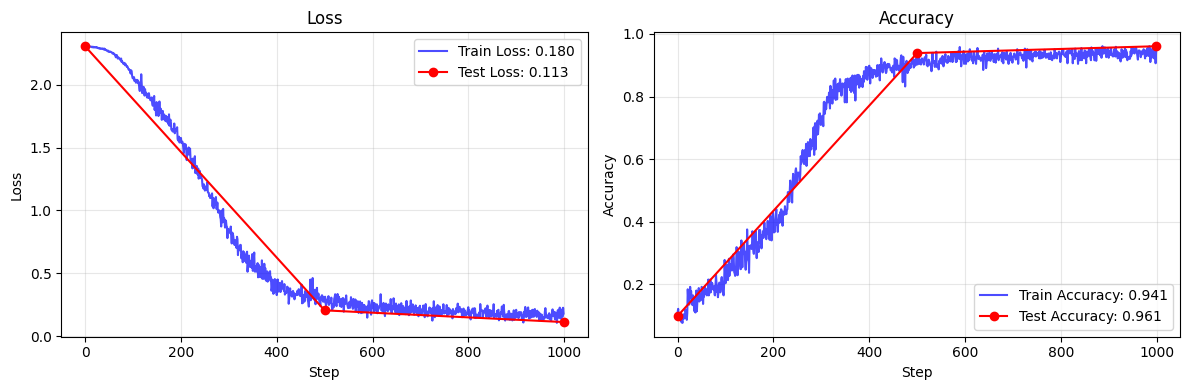

Train Loss: 0.180, Train Accuracy: 0.941, Test Loss: 0.113, Test Accuracy: 0.961:   0%|          | 1/1000 [09:57<165:44:39, 597.28s/it]


In [26]:
model = train(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    iterations=1000,
    test_every=500,
    device=device
)

In [39]:
def make_gif(predictions, 
             certainties, 
             targets, 
             pre_activations, 
             post_activations, 
             attention, 
             inputs_to_model, 
             filename
            ):
    """
    Generates and saves an animated GIF that visualizes predictions, certainties, 
    neuron activations, attention maps, and input reconstructions.
    """
    def reshape_attention_weights(attention, target_size=28):
        # The num_positions will not be a perfect square if the input size is not a perfect square. If d_input is not a perfect sqaure, interpolate
        T, B, num_heads, _, num_positions = attention.shape
        attention = torch.tensor(attention, dtype=torch.float32).mean(dim=2).squeeze(2)
        height = int(num_positions**0.5)
        while num_positions % height != 0: height -= 1
        width = num_positions // height
        attention = attention.view(T, B, height, width)
        return F.interpolate(attention, size=(target_size, target_size), mode='bilinear', align_corners=False)

    batch_index = 0
    n_neurons_to_visualise = 16
    figscale = 0.28
    n_steps = len(pre_activations)
    heCTMap_cmap = sns.color_palette("viridis", as_cmap=True)
    frames = []

    attention = reshape_attention_weights(attention)

    these_pre_acts = pre_activations[:, batch_index, :]
    these_post_acts = post_activations[:, batch_index, :]
    these_inputs = inputs_to_model[batch_index,:, :, :]
    these_attention_weights = attention[:, batch_index, :, :]
    these_predictions = predictions[batch_index, :, :]
    these_certainties = certainties[batch_index, :, :]
    this_target = targets[batch_index]

    class_labels = [str(i) for i in range(these_predictions.shape[0])]

    mosaic = [['img_data', 'img_data', 'attention', 'attention', 'probs', 'probs', 'probs', 'probs'] for _ in range(2)] + \
             [['img_data', 'img_data', 'attention', 'attention', 'probs', 'probs', 'probs', 'probs'] for _ in range(2)] + \
             [['certainty'] * 8] + \
             [[f'trace_{ti}'] * 8 for ti in range(n_neurons_to_visualise)]

    for stepi in range(n_steps):
        fig_gif, axes_gif = plt.subplot_mosaic(mosaic=mosaic, figsize=(31*figscale*8/4, 76*figscale))
        probs = softmax(these_predictions[:, stepi])
        colors = [('g' if i == this_target else 'b') for i in range(len(probs))]

        axes_gif['probs'].bar(np.arange(len(probs)), probs, color=colors, width=0.9, alpha=0.5)
        axes_gif['probs'].set_title('Probabilities')
        axes_gif['probs'].set_xticks(np.arange(len(probs)))
        axes_gif['probs'].set_xticklabels(class_labels, fontsize=24)
        axes_gif['probs'].set_yticks([])
        axes_gif['probs'].tick_params(left=False, bottom=False)
        axes_gif['probs'].set_ylim([0, 1])
        for spine in axes_gif['probs'].spines.values():
            spine.set_visible(False)
        axes_gif['probs'].tick_params(left=False, bottom=False)
        axes_gif['probs'].spines['top'].set_visible(False)
        axes_gif['probs'].spines['right'].set_visible(False)
        axes_gif['probs'].spines['left'].set_visible(False)
        axes_gif['probs'].spines['bottom'].set_visible(False)

        # Certainty
        axes_gif['certainty'].plot(np.arange(n_steps), these_certainties[1], 'k-', linewidth=2)
        axes_gif['certainty'].set_xlim([0, n_steps-1])
        axes_gif['certainty'].axvline(x=stepi, color='black', linewidth=1, alpha=0.5)
        axes_gif['certainty'].set_xticklabels([])
        axes_gif['certainty'].set_yticklabels([])
        axes_gif['certainty'].grid(False)
        for spine in axes_gif['certainty'].spines.values():
            spine.set_visible(False)

        # Neuron Traces
        for neuroni in range(n_neurons_to_visualise):
            ax = axes_gif[f'trace_{neuroni}']
            pre_activation = these_pre_acts[:, neuroni]
            post_activation = these_post_acts[:, neuroni]
            ax_pre = ax.twinx()

            ax_pre.plot(np.arange(n_steps), pre_activation, color='grey', linestyle='--', linewidth=1, alpha=0.4)
            color = 'blue' if neuroni % 2 else 'red'
            ax.plot(np.arange(n_steps), post_activation, color=color, linewidth=2, alpha=1.0)

            ax.set_xlim([0, n_steps-1])
            ax_pre.set_xlim([0, n_steps-1])
            ax.set_ylim([np.min(post_activation), np.max(post_activation)])
            ax_pre.set_ylim([np.min(pre_activation), np.max(pre_activation)])

            ax.axvline(x=stepi, color='black', linewidth=1, alpha=0.5)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(False)
            ax_pre.set_xticklabels([])
            ax_pre.set_yticklabels([])
            ax_pre.grid(False)

            for spine in ax.spines.values():
                spine.set_visible(False)
            for spine in ax_pre.spines.values():
                spine.set_visible(False)

        # Input image
        this_image = these_inputs[0]
        this_image = (this_image - this_image.min()) / (this_image.max() - this_image.min() + 1e-8)
        axes_gif['img_data'].set_title('Input Image')
        axes_gif['img_data'].imshow(this_image, cmap='binary', vmin=0, vmax=1)
        axes_gif['img_data'].axis('off')

        # Attention
        this_input_gate = these_attention_weights[stepi]
        gate_min, gate_max = np.nanmin(this_input_gate), np.nanmax(this_input_gate)
        if not np.isclose(gate_min, gate_max):
            normalized_gate = (this_input_gate - gate_min) / (gate_max - gate_min + 1e-8)
        else:
            normalized_gate = np.zeros_like(this_input_gate)
        attention_weights_heCTMap = heCTMap_cmap(normalized_gate)[:,:,:3]

        axes_gif['attention'].imshow(attention_weights_heCTMap, vmin=0, vmax=1)
        axes_gif['attention'].axis('off')
        axes_gif['attention'].set_title('Attention')

        fig_gif.tight_layout()
        canvas = fig_gif.canvas
        canvas.draw()
        image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:, :, :3]
        frames.append(image_numpy)
        plt.close(fig_gif)


    mediapy.show_video(frames, width=400, codec="gif")
    imageio.mimsave(filename, frames, fps=5, loop=100)

""

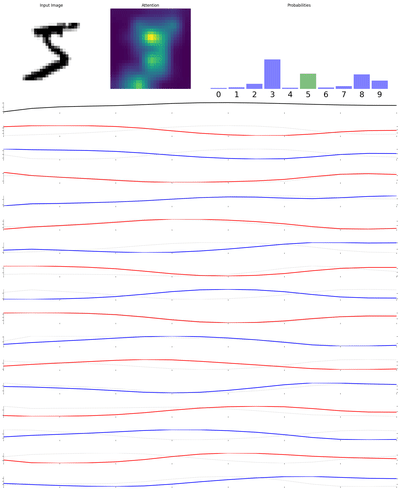

In [46]:
logdir = f"mnist_logs"
if not os.path.exists(logdir):
    os.makedirs(logdir)

model.eval()
with torch.inference_mode():
    inputs, targets = next(iter(testloader))
    inputs = inputs.to(device)

    predictions, certainties, (synch_out_tracking, synch_action_tracking), \
    pre_activations_tracking, post_activations_tracking, attention = model(inputs, track=True)

    make_gif(
        predictions.detach().cpu().numpy(),
        certainties.detach().cpu().numpy(),
        targets.detach().cpu().numpy(),
        pre_activations_tracking,
        post_activations_tracking,
        attention,
        inputs.detach().cpu().numpy(),
        f"{logdir}/prediction.gif"
    )